In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
import scipy.stats as ss
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (8,8)

In [2]:
df = pd.read_csv("diabetes.csv")
df = df[df["BMI"]>10]
dfD = df[df["Outcome"]==1]
dfN = df[df["Outcome"]==0]
dPos = dfD.BMI
dNeg = dfN.BMI
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<h1>Do Diabetics Have a Higher BMI than Normals?</h1>
<h3>This question is both simple and complex - it is easy to say if two things are different at a glance. Analytically though, it becomes more complex. Is that difference significant or irrelevant? Is it due to chance or because of some effect? Stating that a difference matters is not so simple...</h3><br><br><br>
Below we'll look at different ways that we can express an answer to this question, starting with just taking the mean/median, and finishing with effect size. 

<b>First - what are the stats?</b>

In [3]:
#Basics
print("Non-Diabetics mean and median", dNeg.mean(), dNeg.median())
print("Diabetics mean and median", dPos.mean(), dPos.median())

Non-Diabetics mean and median 30.85967413441951 30.1
Diabetics mean and median 35.40676691729318 34.3


<AxesSubplot:xlabel='BMI', ylabel='Density'>

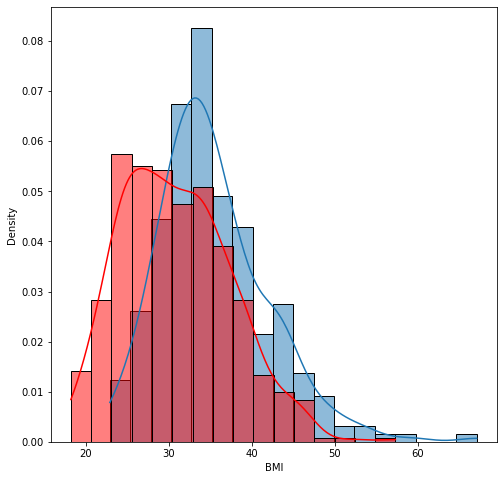

In [4]:
#plot em
sns.histplot(dPos, kde=True, stat="density")
sns.histplot(dNeg, kde=True, stat="density", color='red')


<h3>Looks pretty likely, we should test it though...</h3>

* Without knowing more about the distributions (like the standard deviations) it's hard to interpret whether a difference like this is a lot or not.

* The magnitude of the difference depends on the units of measure, making it hard to compare across different studies.

There are a number of ways to quantify the difference between distributions.  A simple option is to express the difference as a percentage of the mean.

**Exercise 1**: what is the relative difference in means, expressed as a percentage?

In [5]:
#Compute percentage difference
difference_in_means = dPos.mean()-dNeg.mean()
relative_difference = difference_in_means / dPos.mean()
print(relative_difference * 100)   # percent

relative_difference = difference_in_means / dNeg.mean()
print(relative_difference * 100)   # percent

12.842439959274582
14.73474011121215


The problem here with relative differences is that you have to choose which mean to express them relative to.
<br><br><br>

## Part Two

An alternative way to express the difference between distributions is to see how much they overlap.  To define overlap, we choose a threshold between the two means.  The simple threshold is the midpoint between the means:

In [6]:
posMean, negMean, posSTD, negSTD, posMed, negMed = dPos.mean(), dNeg.mean(), dPos.std(), dNeg.std(), dPos.median(), dNeg.median()
simple_thresh = (posMean + negMean) / 2
simple_thresh

33.133220525856345

A better, but slightly more complicated threshold is the place where the PDFs cross.

In [7]:
thresh = (posSTD * negMean + negSTD * posMean) / (posSTD + negSTD)
thresh

33.1238601540465

In this example, there's not much difference between the two thresholds.

Now we can count how many diabetics are below the threshold:

In [8]:
pos_below_thresh = sum(dPos < thresh)
pos_below_thresh

109

And how many non-diabetics are above it:

In [9]:
neg_above_thresh = sum(dNeg > thresh)
neg_above_thresh

179

The "overlap" is the area under the curves that ends up on the wrong side of the threshold.

In [10]:
pos_overlap = pos_below_thresh / len(dPos)
neg_overlap = neg_above_thresh / len(dNeg)
pos_overlap, neg_overlap

(0.40977443609022557, 0.3645621181262729)

In practical terms, you might report the fraction of people who would be misclassified if you tried to use BMI to guess diabeticness, which is the average of the positive and negative overlap rates:

In [11]:
misclassification_rate = (pos_overlap + neg_overlap) / 2
misclassification_rate

0.38716827710824925

Think - ideally, if the diabetic/not-diabetic split was a really good predictor of BMI we'd want this to be as discriminatory as possible. The more overlap, the less diabetic 'means' to the BMI. 

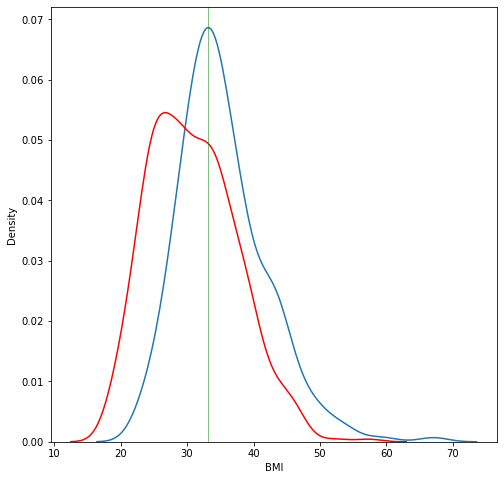

In [12]:
sns.kdeplot(dPos)
sns.kdeplot(dNeg, color='red')
thinkplot.axvline(thresh, color="green")

Another way to quantify the difference between distributions is what's called "probability of superiority", which is a problematic term, but in this context it's the probability that a randomly-chosen diabetic has a higher BMI than a randomly-chosen non-diabetic.

**Exercise 2**:  Suppose I choose a diabetic and a normal at random.  What is the probability that the diabetic has a higher BMI?

HINT: You can `zip` the two samples together and count the number of pairs where the diabetic has a higher BMI, or use NumPy array operations.

In [13]:
sum(x > y for x, y in zip(dPos, dNeg)) / len(dPos)

0.6654135338345865

### Cohen's effect size

There is one other common way to express the difference between distributions - our old friend Cohen and his Effect Size.  Cohen's $d$ is the difference in means, standardized by dividing by the standard deviation.  Here's the math notation:

$ d = \frac{\bar{x}_1 - \bar{x}_2} s $

where $s$ is the pooled standard deviation:

$s = \sqrt{\frac{n_1 s^2_1 + n_2 s^2_2}{n_1+n_2}}$

Here's a function that computes it:

In [14]:
def CohenEffectSize(group1, group2):
    """Compute Cohen's d.

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

Computing the denominator is a little complicated; in fact, people have proposed several ways to do it.  This implementation uses the "pooled standard deviation", which is a weighted average of the standard deviations of the two groups.

And here's the result for the difference in BMI between diabetics and normals.

In [15]:
CohenEffectSize(dPos, dNeg)

0.6910633931865521

It isn't really super obvious what this value means, unfortunately.

Here's a function that encapsulates the code we already saw for computing overlap and probability of superiority.

In [16]:
def overlap_superiority(control, treatment, n=1000):
    """Estimates overlap and superiority based on a sample.
    
    control: scipy.stats rv object
    treatment: scipy.stats rv object
    n: sample size
    """
    control_sample = control.rvs(n)
    treatment_sample = treatment.rvs(n)
    thresh = (control.mean() + treatment.mean()) / 2
    
    control_above = sum(control_sample > thresh)
    treatment_below = sum(treatment_sample < thresh)
    overlap = (control_above + treatment_below) / n
    
    superiority = (treatment_sample > control_sample).mean()
    return overlap, superiority

In [17]:
def eval_pdf(rv, num=4):
    mean, std = rv.mean(), rv.std()
    xs = np.linspace(mean - num*std, mean + num*std, 100)
    ys = rv.pdf(xs)
    return xs, ys

<h2>Visualizing what Cohen's Effect Size looks like</h2>

Here's the function that takes Cohen's $d$, plots normal distributions with the given effect size, and prints their overlap and superiority. We can look at this to get an idea of what the values we may get for Cohen are visually. 

In [18]:
def plot_pdfs(cohen_d=2):
    """Plot PDFs for distributions that differ by some number of stds.
    
    cohen_d: number of standard deviations between the means
    """
    control = ss.norm(0, 1)
    treatment = ss.norm(cohen_d, 1)
    xs, ys = eval_pdf(control)
    plt.fill_between(xs, ys, label='control', color='C1', alpha=0.5)

    xs, ys = eval_pdf(treatment)
    plt.fill_between(xs, ys, label='treatment', color='C0', alpha=0.5)
    
    o, s = overlap_superiority(control, treatment)
    plt.text(0, 0.05, 'overlap ' + str(o))
    plt.text(0, 0.15, 'superiority ' + str(s))
    plt.show()
    #print('overlap', o)
    #print('superiority', s)

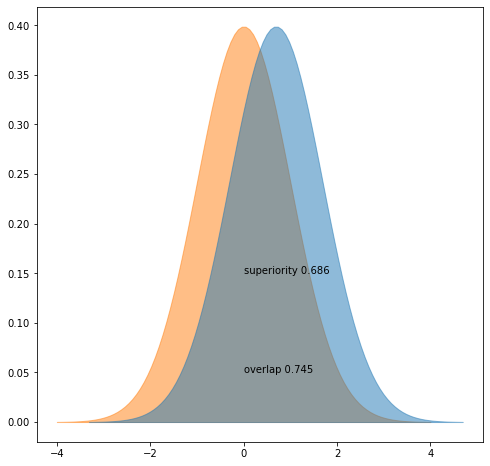

In [19]:
dCohen = CohenEffectSize(dPos, dNeg)
plot_pdfs(dCohen)

The chart below does the same basic thing, but we can use a little widget in Python that allows us to edit the value for the effect size dynamically.  

In [20]:
slider = widgets.FloatSlider(min=0, max=4, value=dCohen)
interact(plot_pdfs, cohen_d=slider);

interactive(children=(FloatSlider(value=0.6910633931865521, description='cohen_d', max=4.0), Output()), _dom_c…

<h2>Effect Size - What Did We Find?</h2>
<br>
<p>
We want to be able to say if there's a real difference between group A and group B. All of the caclualtions above are different ways to demonstrate that - they aren't the only ways!

Cohen's Effect Size is a very good metric to use. 

<h1>Odds</h1>

We can look at at similar problem - how likely is it that someone with or without diabetes has a BMI that is obese (>=30)?

Odds ratios are another type of effect size. 

In [26]:
#Probability of being overweight
pPos = sum(dPos >= 30)/len(dPos)
pNeg = sum(dNeg >= 30)/len(dNeg)
pPos, pNeg

(0.8233082706766918, 0.515274949083503)

How much of a difference does being diabetic make?

In [27]:
pPos/pNeg, pNeg/pPos

(1.5978037980326312, 0.6258590705763096)

<h3>Being diabetic increases the chances of being obese by 159%. But being not diabetic decreases chances of obesity by 63%. What is the right way to express this?</h3>

Probabilities are pretty high! We can express probabilities in a slightly different way as well - as odds.

odds = p/(1-p)

Odd are just the ratio of the likelihood something happens to the likelihood that it doesn't.

If you've ever gambled, you've seen odds, eg if there is a game between two teams, and one is heavily favored you may see odds like
<ul>
<li>Miami Dolphins 11/2 (+550)
<li>Buffalo Bills 2/19 (-850)
</ul>

This means that for every two dollars you bet on Miami you'll win 11 - they are much less likely to win. For every 19 dollars you bet on Buffalo, you'l only win 2! They are extremely likely to win. (Gambling note: if you win in either case, you get back the original bet - the odds only look at winnings.) (Gambling note #2, in North America we normally use the +/- version, which are expressed in terms of "what would happen if I bet $100, called American odds.)

In [23]:
#Calculate odds
oddPos = pPos/(1-pPos)
oddNeg = pNeg/(1-pNeg)
oddPos, oddNeg

(4.659574468085108, 1.0630252100840334)

In [24]:
#We can  calculate a ratio of these two
oddPos/oddNeg, oddNeg/oddPos

(4.383315112269786, 0.2281378304746555)

So... being diabetic increases chances of obesity (or=4.4). 

Or 

Not being diabetic decreases chances of obesity (or=.23)

Which one matters? It isn't really clear. <br><br><br>

<h3>Can math help? Take the log...</h3>

In [25]:
#Log of the odds.
logNeg = np.log(oddNeg/oddPos)
logPos = np.log(oddPos/oddNeg)
logNeg, logPos

(-1.4778053130503972, 1.4778053130503972)

<b>Same, same!!!</b>

This is called the log odds ratio, or logit. Put this into your back pocket, it becomes important when we want to start predicting things pretty soon....

Log odds ratio is excellent for comparisons of probabilites, it is symetric and we can compare accross studies. On the downside, it is kind of a meaningless metric to most people. On the double plus side, this is the building block of classifications, specifically logistic regression, which we'll look at more soon. 